In [1]:
import glob
import os, sys
os.path.abspath(os.getcwd())
sys.path.append("C:\\Users\\abel_\\Documents\\Rotations\\CIT\\cit_for_computation")

import torch
import torch.nn as nn
import pandas
import numpy as np
import numpy.ma as ma
import pickle
import time
from tqdm.notebook import tqdm
import matplotlib.cm as cmx
import sklearn
import sklearn.decomposition

import proplot as pplt
import sklearn
from fractions import Fraction

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device = 'cpu'
from utils import *

C:\Users\abel_\anaconda3\envs\CIT_\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [25]:
current_dir = 'C:\\Users\\abel_\\Documents\\Rotations\\CIT\cit_for_computation'
exp_extension = "\\experiments\\poisson_clicks\\"

#not normalized: *19
#normalized: 04, 100, 99
exp_list = glob.glob(current_dir + exp_extension + "\\exp*04") #99
exp_path = exp_list[0]
with open(exp_path + '\\training_kwargs.pickle', 'rb') as handle:
    training_kwargs = pickle.load(handle)

training_kwargs['exp_path'] = exp_path
training_kwargs['training_weights_path'] = exp_path + '/training/'
training_kwargs['figures_path'] = exp_path + '//figures/'

N_rec = training_kwargs['N_rec']
N_in =  training_kwargs['N_in']
N_out = training_kwargs['N_out']

rnn_model = RNNModel(N_in, N_out, N_rec, n_layers=1, transform_function='relu').to(device)
rnn_model = load_model(rnn_model, training_kwargs).to(device)

In [38]:
#LOAD/GENERATE DATA
N_test_batch = 5000
training_kwargs['sum_of_rates'] = 1
training_kwargs['clicks_capped'] = True
training_kwargs['fixed_stim_duration_list'] = [100]
training_kwargs['fixed_cue_onsetandduration']= [10, 5, 20, 50]
pd = PoissonClicks(N_batch=N_test_batch, training_kwargs=training_kwargs)
x, y, output_mask, trial_params = pd.get_trial_batch() #generate self.N_batch trials

inputs = torch.tensor(x, dtype=torch.float).to(device)

#initialize hidden states
hidden = torch.normal(0, training_kwargs['hidden_initial_variance'], (rnn_model.n_layers, inputs.shape[0], rnn_model.hidden_dim)).to(device) #random?
hidden_states, hidden_last = rnn_model.rnn(inputs, hidden)
yhat = rnn_model.fc(hidden_states)
yhat =  rnn_model.softmax(yhat)
yhat = yhat.cpu().detach().numpy()
hidden_states = hidden_states.cpu().detach().numpy()
flat_hidden_states = hidden_states.reshape((-1, hidden_states.shape[-1]))

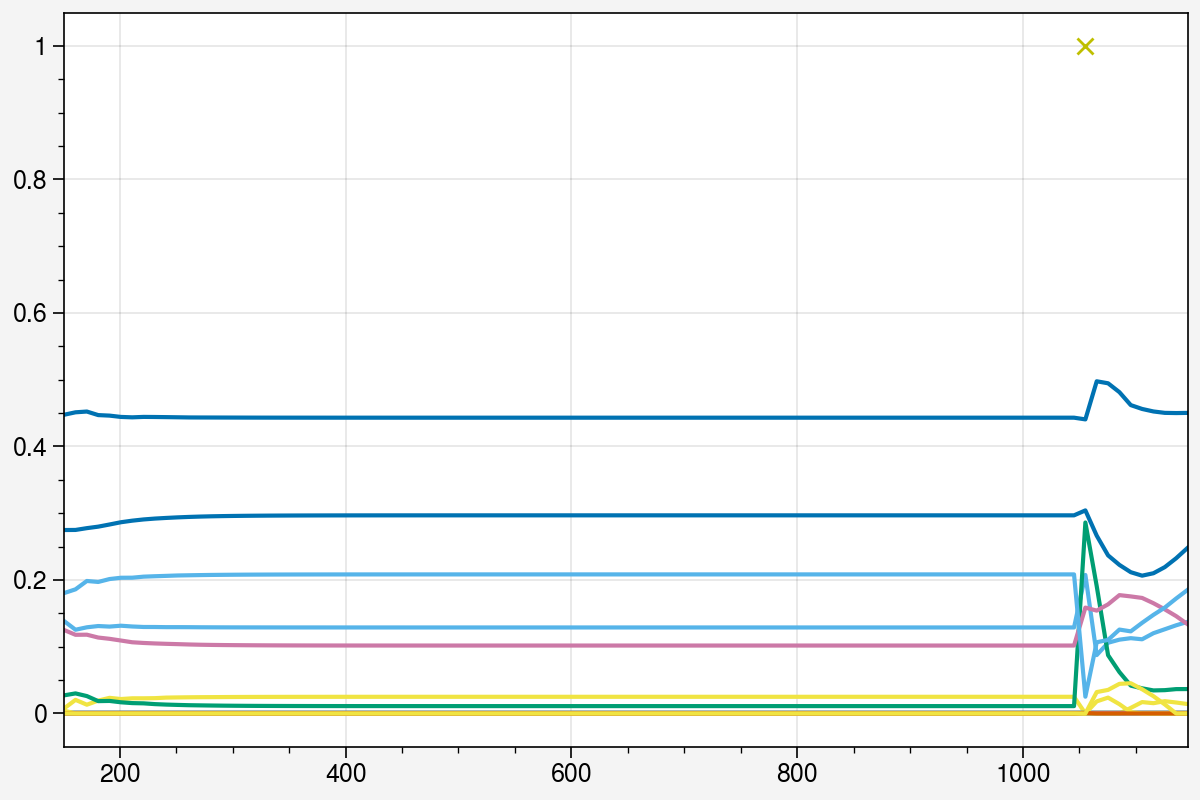

In [39]:
trial_i = 5

pplt.figure(figsize=(6,4))
ax = plt.subplot(111)
times = np.linspace(0, training_kwargs['T'], yhat[trial_i, :, 0].shape[0])

ax.plot(times[trial_params[trial_i]['stim_durations_and_pauses'][0]:sum(trial_params[trial_i]['stim_durations_and_pauses'])],
        hidden_states[trial_i, trial_params[trial_i]['stim_durations_and_pauses'][0]:sum(trial_params[trial_i]['stim_durations_and_pauses']), :]);

ax.plot(times, np.where(x[trial_i,:,0]>0., x[trial_i,:,0], np.nan), 'xb')
ax.plot(times, np.where(x[trial_i,:,1]>0., x[trial_i,:,1], np.nan), 'xy');

In [40]:
# accuracy, response_correctness, choice_proportion_per_ratio, average_accuracy_per_ratio, N_clicks, highest_click_count_index, chosen, excludeequals = get_accuracy_poissonclicks_w(test_x, yhat, output_mask, trial_params)
accuracy, response_correctness, choice_proportion_per_ratio, average_accuracy_per_ratio, N_clicks, highest_click_count_index, chosen = get_accuracy_poissonclicks(x, yhat, output_mask, trial_params)

hidden_states_input_and_init = [hidden_states[i][:sum(trial_params[i]['stim_durations_and_pauses']),:] for i in range(hidden_states.shape[0])]
hidden_states_input = [hidden_states[i][trial_params[i]['stim_durations_and_pauses'][0]:sum(trial_params[i]['stim_durations_and_pauses']),:] for i in range(hidden_states.shape[0])]


hidden_states_output = [hidden_states[i][trial_params[i]['output_cue']:,:] for i in range(hidden_states.shape[0])]

df = pandas.DataFrame.from_records(trial_params)
df["Choice"] = chosen
df["Difference"] = N_clicks[:,0]-N_clicks[:,1]
average_perclick = df.groupby("Difference").mean()
neg_click_idx = np.where(df["Difference"]<0.)[0]
pos_click_idx = np.where(df["Difference"]>0.)[0]

accuracy

0.4078

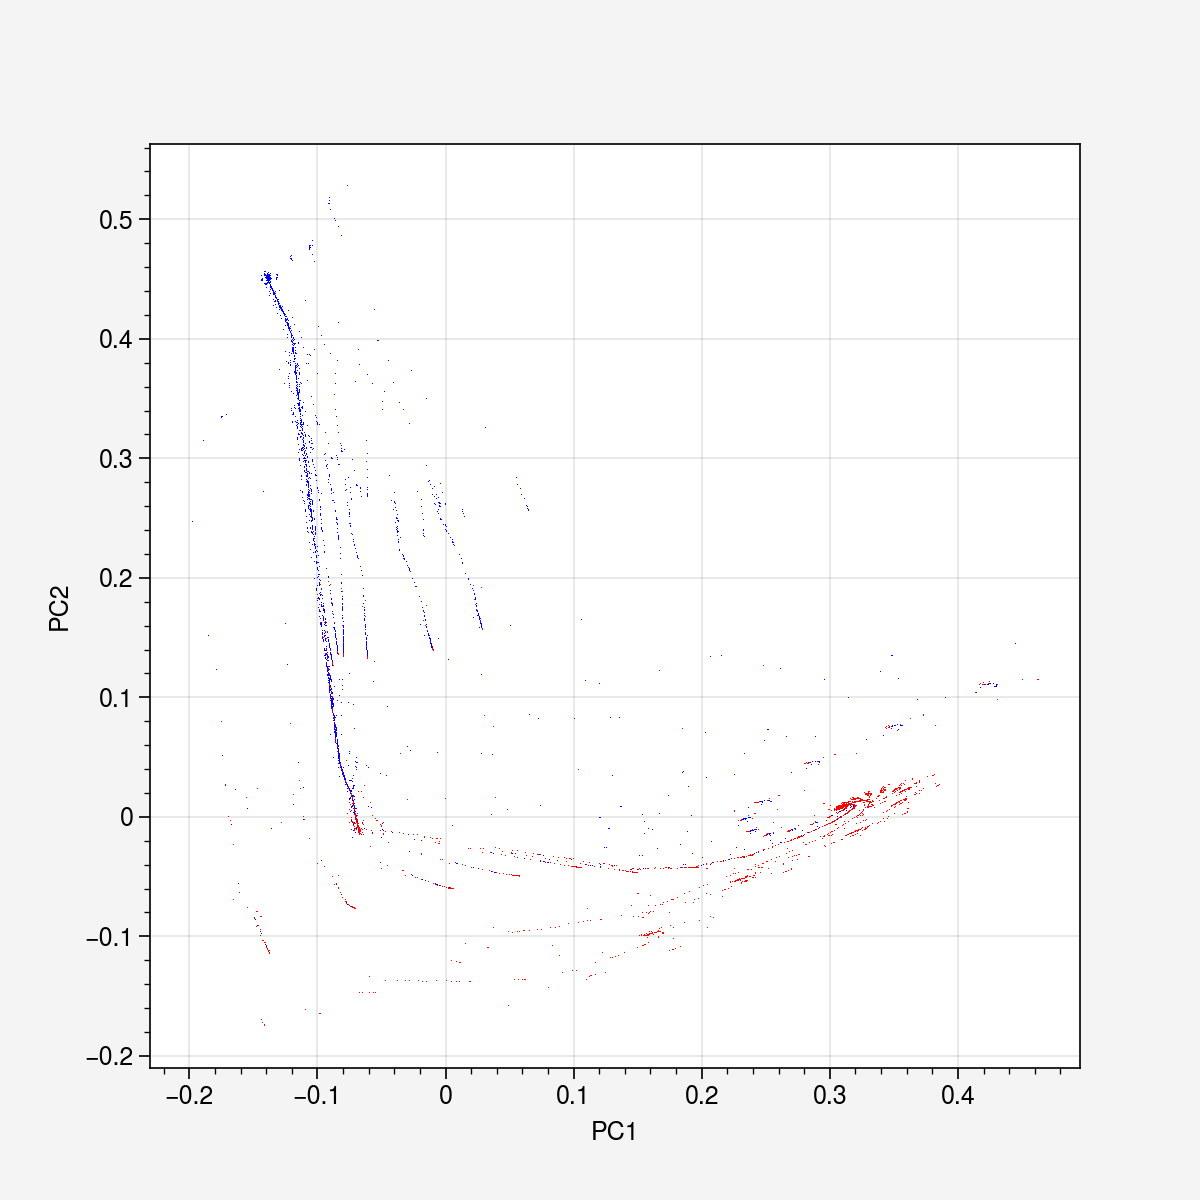

In [41]:
###PCA of hidden states during input
flat_hidden_states_input = np.concatenate(hidden_states_input)

if training_kwargs['N_rec'] < 11:
    n_components = training_kwargs['N_rec']
else:
    n_components = 10
pca = sklearn.decomposition.PCA(n_components=n_components)
X_new = pca.fit_transform(flat_hidden_states_input)
trajectories = X_new.reshape((N_test_batch, -1, n_components))

plt.figure(figsize=(6,6))
# plt.plot(X_new[:,0], X_new[:,1], '.')
N_points = 500
# plt.plot(X_new[:N_points,0], X_new[:N_points,1], '.')
plt.plot(trajectories[neg_click_idx,:,0], trajectories[neg_click_idx,:,1], 'b,')
plt.plot(trajectories[pos_click_idx,:,0], trajectories[pos_click_idx,:,1], 'r,')
plt.xlabel("PC1")
plt.ylabel("PC2");
# plt.savefig(training_kwargs['figures_path'] + '\\pca_inputs_cohlist_small_ncomp%s.pdf'%(2))
# plt.savefig(training_kwargs['figures_path'] + '\\pca_inputs_cohlist_small_ncomp%s.png'%(2))

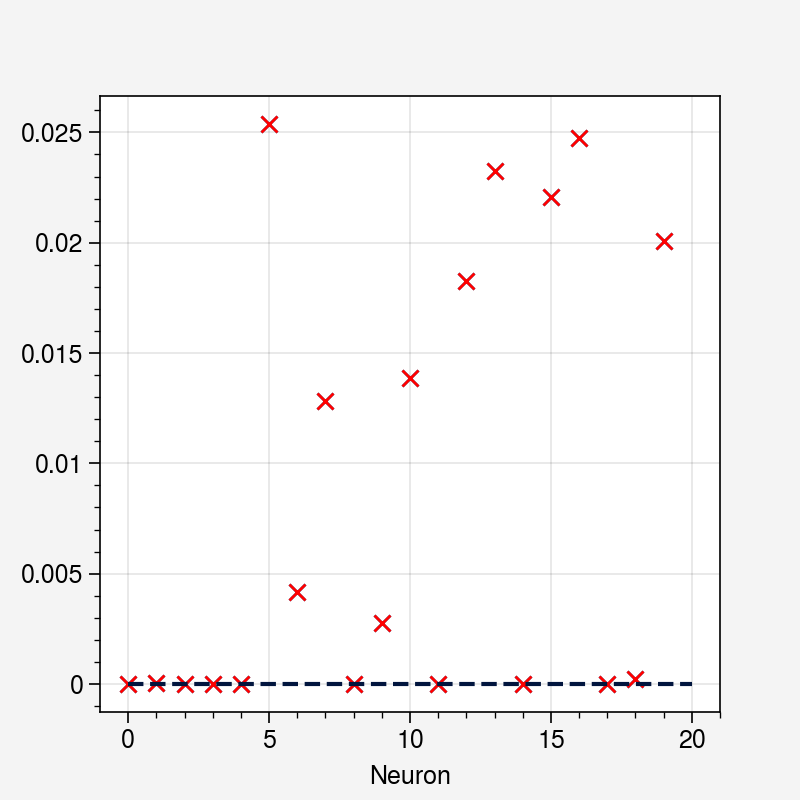

In [172]:
loading_matrix = pca.components_.T * np.sqrt(pca.explained_variance_)

meanabs_lm = np.abs(loading_matrix).mean(axis=1)
plt.plot(meanabs_lm, 'x')

select_n_neurons = 20
select_idx = np.argsort(meanabs_lm)[-select_n_neurons:]
# select_idx = np.where(meanabs_lm>0.01)[0]
plt.plot(select_idx, meanabs_lm[select_idx], 'rx')
plt.plot([0, 20], [meanabs_lm[select_idx[-select_n_neurons]], meanabs_lm[select_idx[-select_n_neurons]]], color="navy", linestyle="--");
plt.xlabel("Neuron");

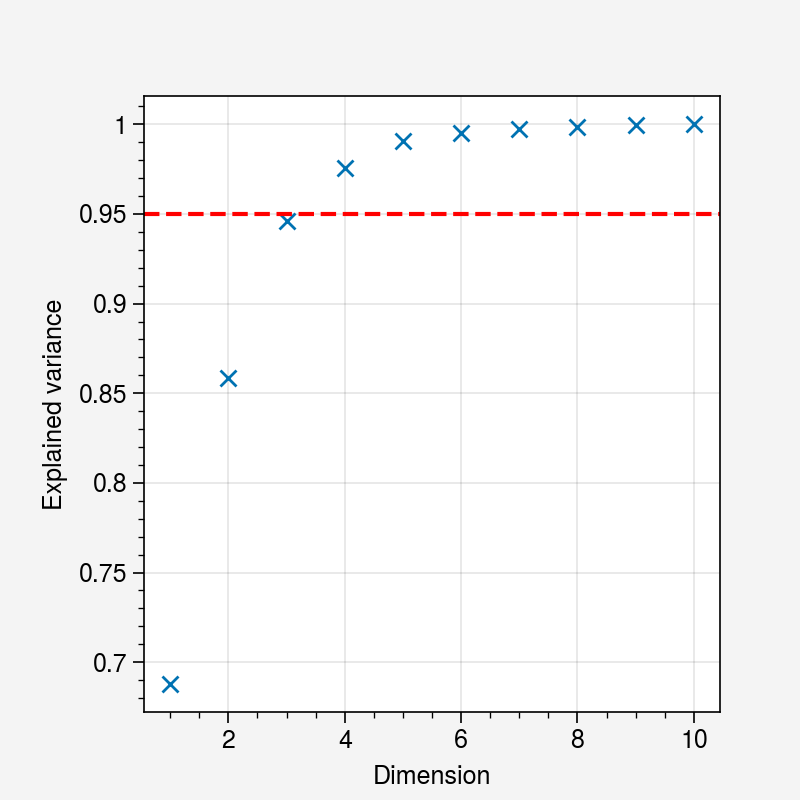

In [173]:
# pca.get_covariance()
plt.plot(range(1, n_components+1), pca.explained_variance_ratio_.cumsum(), 'x')
plt.axhline(y=0.95, color = 'r', linestyle = '--')
plt.xlabel("Dimension")
plt.ylabel("Explained variance");
plt.gcf().subplots_adjust(left=0.18)

plt.savefig(training_kwargs['figures_path'] + '\\varexpl_input_cohlist.pdf')

C:\Users\abel_\AppData\Local\Temp\ipykernel_16180\146141999.py:8: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


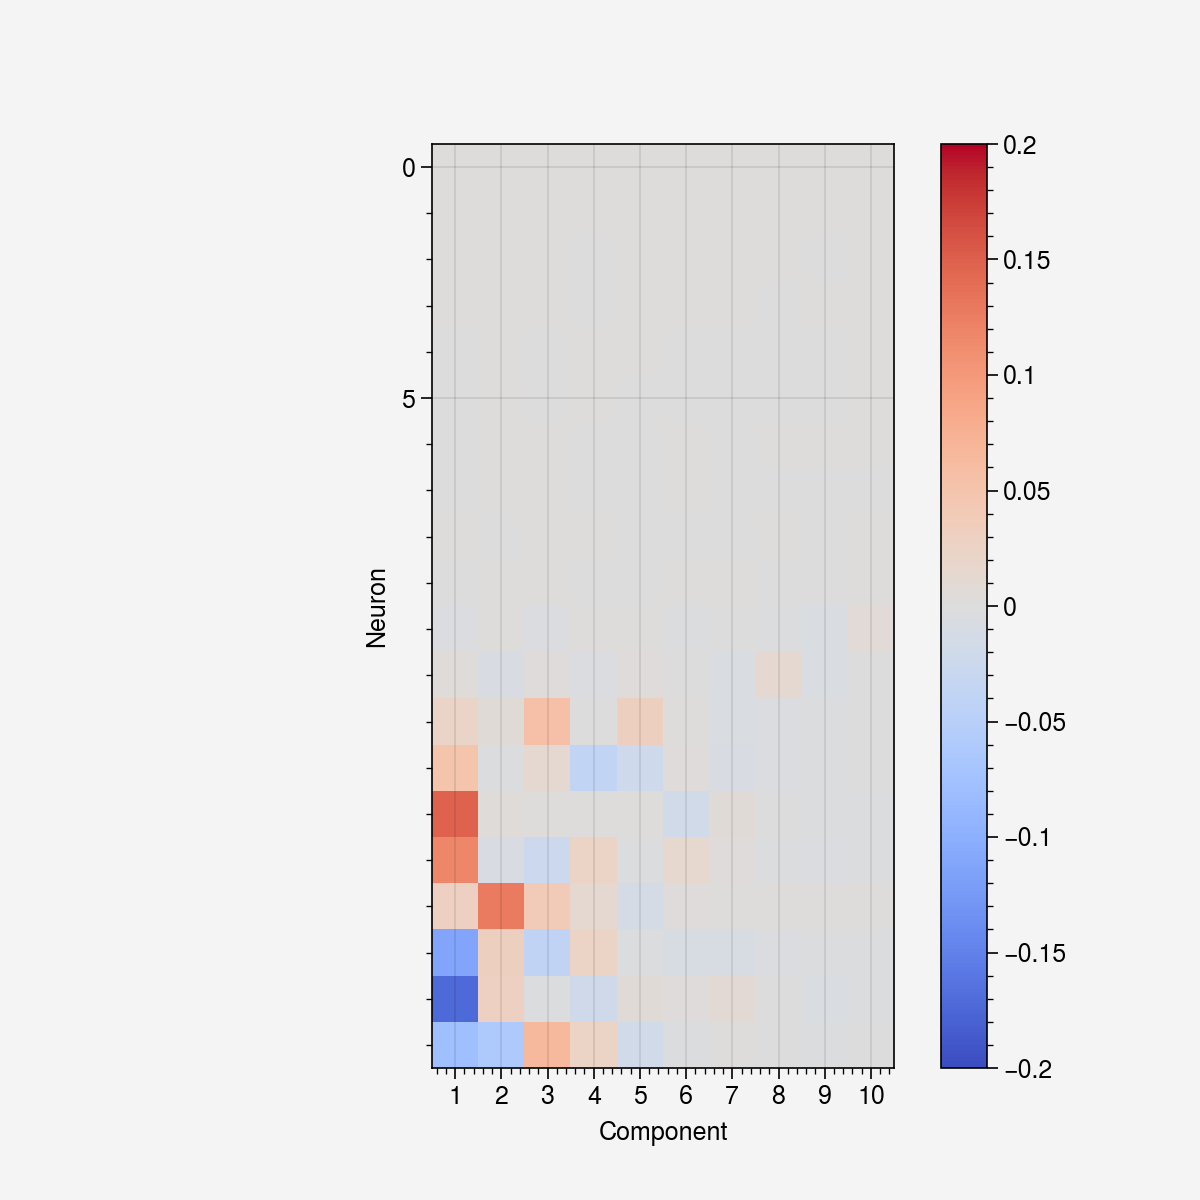

In [174]:
fig=plt.figure(figsize=(6,6))
ax = plt.subplot(111)
plt.imshow(loading_matrix[select_idx], cmap="coolwarm", vmin=-.2, vmax=.2)
plt.xticks(range(0,n_components),range(1,n_components+1))
plt.yticks(range(0,10, 5))
plt.xlabel("Component")
plt.ylabel("Neuron")
plt.colorbar()
# plt.savefig(training_kwargs['figures_path'] + '\\loadingmat_inputs_cohlist.pdf')
# plt.savefig(training_kwargs['figures_path'] + '\\loadingmat_inputs_cohlist.png')

In [175]:
rnn_small = RNNModel(N_in, N_out, select_idx.shape[0], n_layers=1, transform_function='relu').to(device)

with torch.no_grad():
    rnn_small.rnn.all_weights[0][0][:] = rnn_model.rnn.all_weights[0][0][select_idx].clone().detach()
    rnn_small.rnn.all_weights[0][1][:] = rnn_model.rnn.all_weights[0][1][select_idx[:,None], select_idx].clone().detach()
    #biases of hidden neuron
    rnn_small.rnn.all_weights[0][2][:] =  rnn_model.rnn.all_weights[0][2][select_idx].clone().detach()
    rnn_small.rnn.all_weights[0][3][:] =  rnn_model.rnn.all_weights[0][3][select_idx].clone().detach()
    #fully connected layers
    rnn_small.fc.weight = nn.Parameter(rnn_model.fc.weight[:,select_idx].clone().detach())
    rnn_small.fc.bias = nn.Parameter(rnn_model.fc.bias.clone().detach())

In [72]:
torch.save(rnn_small.state_dict(), training_kwargs['exp_path'] + '/restricted_weights_n%s.pth'%select_n_neurons)

In [73]:
# torch.cuda.empty_cache()

In [164]:
#LOAD/GENERATE DATA
yhat, hidden = rnn_small(inputs)
yhat = yhat.cpu().detach().numpy()

#initialize hidden states
hidden = torch.normal(0, training_kwargs['hidden_initial_variance'], (rnn_small.n_layers, inputs.shape[0], rnn_small.hidden_dim)).to(device) #random?
hidden_states, hidden_last = rnn_small.rnn(inputs, hidden)

yhat = rnn_small.fc(hidden_states)
yhat = rnn_small.softmax(yhat).cpu().detach().numpy()

hidden_states = hidden_states.cpu().detach().numpy()
flat_hidden_states = hidden_states.reshape((-1, hidden_states.shape[-1]))

In [165]:
# accuracy, response_correctness, choice_proportion_per_ratio, average_accuracy_per_ratio, N_clicks, highest_click_count_index, chosen, excludeequals = get_accuracy_poissonclicks_w(test_x, yhat, output_mask, trial_params)
accuracy, response_correctness, choice_proportion_per_ratio, average_accuracy_per_ratio, N_clicks, highest_click_count_index, chosen = get_accuracy_poissonclicks(x, yhat, output_mask, trial_params)

hidden_states_input = [hidden_states[i][:sum(trial_params[i]['stim_durations_and_pauses']),:] for i in range(hidden_states.shape[0])]

hidden_states_output = [hidden_states[i][trial_params[i]['output_cue']:,:] for i in range(hidden_states.shape[0])]

df = pandas.DataFrame.from_records(trial_params)
df["Choice"] = chosen
df["Difference"] = N_clicks[:,0]-N_clicks[:,1]
average_perclick = df.groupby("Difference").mean()
neg_click_idx = np.where(df["Difference"]<0.)[0]
pos_click_idx = np.where(df["Difference"]>0.)[0]

In [166]:
accuracy

0.9822